In [ ]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2

BATCH_SIZE = 4
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 128
D_HIDDEN = 64
EPOCH_NUM = 20000
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.001
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True

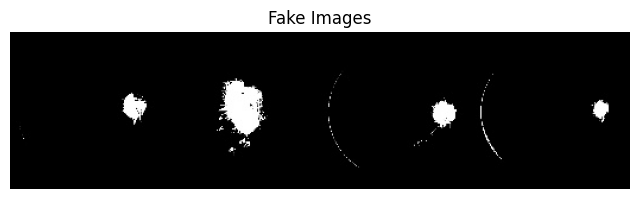

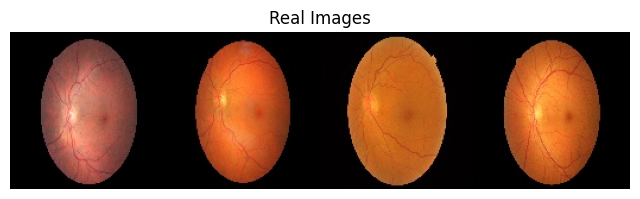

In [13]:
##Generator Input Data##
transform = transforms.Compose([transforms.ToTensor()])
class vector_Dataset():
    def __init__(self,transform=None):
        self.files=os.listdir('/kaggle/input/gan-major-test-data128/GAN_inputs/optic')
        #print(self.files)
        self.file_name=[]
        for file in self.files:
            basename, extension = os.path.splitext(file)
            self.file_name.append(basename)
            
    def __len__(self):
        return(len(self.files))
    
    def __getitem__(self,idx):
        optic=cv2.imread(f'/kaggle/input/gan-major-test-data128/GAN_inputs/optic/{self.file_name[idx]}.jpg')
        optic=cv2.resize(optic,(128,128))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2GRAY)
        plt.imshow(optic)
        plt.show()
        optic=transform(optic)#.to(device)
        
        return optic

in_dataset=vector_Dataset()

# Dataloader
G_inputs = torch.utils.data.DataLoader(in_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)    

"""# Plot some training images
input_batch = next(iter(G_inputs))
print(input_batch.shape)
print('Input_BATCH_SIZE: ',len(input_batch))
#print(input_batch)
print('Image Size: ',input_batch[0].shape)
#print('After loading: ',input_batch[1].shape)
#print('After loading: ',input_batch[2].shape)
#print('After loading: ',input_batch[3].shape)

for i in range(len(input_batch)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(input_batch[i].permute(1,2,0).detach().cpu().numpy(), cmap="gray") #change to proper RGB nd.Array
plt.show()"""

# Plot some training images
Data=next(iter(G_inputs))
#print(Data)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(Data.to(device), nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()



##Discriminator Traing Data##
"""transform = transforms.Compose([transforms.ToTensor()])
class training_Dataset():
    def __init__(self,transform=None):
        root_dir=r'/kaggle/input/gan-test-data/Image_DATA/GAN_input/64x64/original'
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
            
    def __len__(self):
        return(len(self.image_paths))
    
    def __getitem__(self,idx):
        optic=cv2.imread(self.image_paths[idx])
        optic=cv2.resize(optic,(64,64))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2RGB)
        optic=transform(optic)#.to(device)
        
        return optic

train_dataset=training_Dataset()

# Dataloader
D_inputs = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)"""

# Data preprocessing
dataset = dset.ImageFolder(root=r'/kaggle/input/gan-major-test-data128/Test',
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True,
                                         shuffle=True, num_workers=4)

# Plot some training images
Data=next(iter(dataloader))
#print(Data)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(Data[0].to(device), nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
def display_images(img_list):
    # Plot some fake images
    fake_batch = img_list[-1] #next(iter(img_list))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()
    
# Generate image
def save_image(fake):
    %mkdir /kaggle/working/Generated_Batch
    print('Generated Image Size: ',fake[0].shape)
    for i,genrated_image in enumerate(fake):
        #print(i)
        genrated_image = np.moveaxis(genrated_image, 0, -1)
        #print(genrated_image.shape)
        m = np.min(genrated_image)
        M = np.max(genrated_image)
        genrated_image = (genrated_image-m)/(M-m)
        genrated_image = 255*genrated_image
        genrated_image = np.array(genrated_image, dtype='uint8')
        #plt.imshow(genrated_image)
        #plt.show()
        plt.imsave(f'/kaggle/working/Generated_Batch/{i}.png', genrated_image)

        source_folder = '/kaggle/working/Generated_Batch'
        output_path = '/kaggle/working/'
        shutil.make_archive('Output', 'zip', source_folder)

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data.shape)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[1],nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

def generate_Image(noise):
    #netG.to(device)
    #netG.load_state_dict(torch.load('/kaggle/input/gan-main-weights-900/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/working/200/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/input/weights128-3000/generator.weight'))
    

    #noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    with torch.no_grad():
        #print(noise.shape)
        fake = netG(noise)#.detach().cpu()#.numpy()
    
    #save_image(netG(noise).detach().cpu().numpy())        
    display_image(fake,'Fake')#

In [14]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class downsampler(nn.Module):
    # initializers
    def __init__(self, d=4):
        super(downsampler, self).__init__()
        self.conv1 = nn.Conv2d(1, d,kernel_size=65, stride=1, padding=0)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2,kernel_size=33, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4,kernel_size=17, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8,kernel_size=16, stride=1, padding=0)
        self.linear=nn.Linear(32,100).to(device)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        print('shape after Layer1: ',x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print('shape after Layer2: ',x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print('shape after Layer3: ',x.shape)
        #x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #print('shape after Layer4: ',x.shape)
        x = self.conv4(x)
        print('shape after Layer4: ',x.shape) 
        x = self.linear(torch.flatten(x, start_dim=1))#, end_dim=2
        print('shape after Linear Layer: ',x.shape)        

        return x
    
class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*16, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*16)
        self.deconv2 = nn.ConvTranspose2d(d*16, d*8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*8)
        self.deconv3 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*4)
        self.deconv4 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d*2)
        self.deconv5 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d)
        self.deconv6 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        # 1x1 to 4x4 to 8x8 to 16x16 to 32x32 to 64x64 to 128x128

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        x = F.tanh(self.deconv6(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*16, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d*16)
        self.conv6 = nn.Conv2d(d*16, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        x = F.sigmoid(self.conv6(x))

        return x

# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

#create Downsampler instance
Dsmplr = downsampler()
Dsmplr.to(device)
print(Dsmplr)

for i,data in enumerate(G_inputs,0):
    datapoint = data.to(device)
    b_size = datapoint.size(0)
    print(b_size)
    print('\noriginal shape: ',datapoint.shape)
    tensor=Dsmplr.forward(datapoint)
print(tensor.shape)

# Reshape to (4, 100, 1, 1)
noise = tensor.view(4, 100, 1, 1)
print('New Input Noise Size: ',noise.shape)
#print(tensor)
generate_Image(noise)

generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2)

Starting Training Loop...
[1/20000][0/263]	Loss_D: 1.4491	Loss_G: 27.2367	D(x): 0.4969	D(G(z)): 0.5211 / 0.0000
[2/20000][0/263]	Loss_D: 0.9359	Loss_G: 1.0480	D(x): 0.5157	D(G(z)): 0.1415 / 0.3626
[3/20000][0/263]	Loss_D: 2.2122	Loss_G: 0.6805	D(x): 0.2221	D(G(z)): 0.2303 / 0.5266
[4/20000][0/263]	Loss_D: 1.7789	Loss_G: 1.7461	D(x): 0.3032	D(G(z)): 0.0657 / 0.1870
[5/20000][0/263]	Loss_D: 1.9629	Loss_G: 1.4634	D(x): 0.2062	D(G(z)): 0.0419 / 0.2538
[6/20000][0/263]	Loss_D: 2.1582	Loss_G: 1.2168	D(x): 0.1886	D(G(z)): 0.1145 / 0.3163
[7/20000][0/263]	Loss_D: 1.3975	Loss_G: 0.9372	D(x): 0.3503	D(G(z)): 0.2566 / 0.3968
[8/20000][0/263]	Loss_D: 0.8968	Loss_G: 1.3807	D(x): 0.5555	D(G(z)): 0.2415 / 0.2524
[9/20000][0/263]	Loss_D: 0.9349	Loss_G: 2.4026	D(x): 0.5849	D(G(z)): 0.3031 / 0.1226
[10/20000][0/263]	Loss_D: 0.2890	Loss_G: 2.5490	D(x): 0.9293	D(G(z)): 0.1795 / 0.0947
[11/20000][0/263]	Loss_D: 0.3244	Loss_G: 3.5911	D(x): 0.9852	D(G(z)): 0.2656 / 0.0293
[12/20000][0/263]	Loss_D: 1.5511	Los

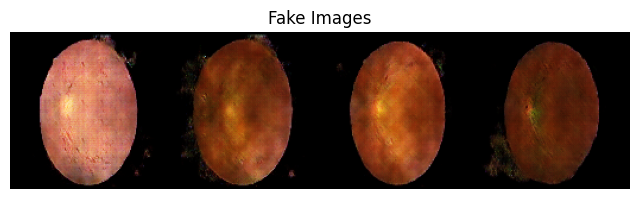

[21/20000][0/263]	Loss_D: 0.7777	Loss_G: 1.7496	D(x): 0.5982	D(G(z)): 0.1747 / 0.1983
[22/20000][0/263]	Loss_D: 0.8148	Loss_G: 1.9379	D(x): 0.9968	D(G(z)): 0.5537 / 0.1830
[23/20000][0/263]	Loss_D: 0.0458	Loss_G: 4.1626	D(x): 0.9944	D(G(z)): 0.0392 / 0.0163
[24/20000][0/263]	Loss_D: 0.3519	Loss_G: 2.8640	D(x): 0.9998	D(G(z)): 0.2957 / 0.0614
[25/20000][0/263]	Loss_D: 0.3299	Loss_G: 2.0534	D(x): 0.9958	D(G(z)): 0.2767 / 0.1352
[26/20000][0/263]	Loss_D: 1.2664	Loss_G: 2.2629	D(x): 0.6540	D(G(z)): 0.3436 / 0.1316
[27/20000][0/263]	Loss_D: 1.2625	Loss_G: 0.8861	D(x): 0.4975	D(G(z)): 0.3221 / 0.4258
[28/20000][0/263]	Loss_D: 0.1962	Loss_G: 3.1254	D(x): 0.9978	D(G(z)): 0.1762 / 0.0455
[29/20000][0/263]	Loss_D: 0.0711	Loss_G: 3.5569	D(x): 0.9970	D(G(z)): 0.0655 / 0.0296
[30/20000][0/263]	Loss_D: 0.3093	Loss_G: 2.2280	D(x): 0.9939	D(G(z)): 0.2614 / 0.1124
[31/20000][0/263]	Loss_D: 0.9289	Loss_G: 2.2908	D(x): 0.4460	D(G(z)): 0.1013 / 0.1123
[32/20000][0/263]	Loss_D: 0.3638	Loss_G: 2.1206	D(x): 

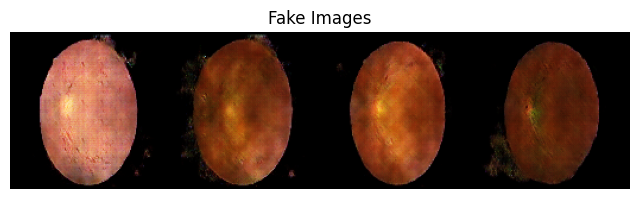

[41/20000][0/263]	Loss_D: 0.6442	Loss_G: 1.9709	D(x): 0.6379	D(G(z)): 0.0911 / 0.2422
[42/20000][0/263]	Loss_D: 0.4497	Loss_G: 1.7670	D(x): 1.0000	D(G(z)): 0.3527 / 0.1770
[43/20000][0/263]	Loss_D: 0.4096	Loss_G: 2.2646	D(x): 1.0000	D(G(z)): 0.3345 / 0.1050
[44/20000][0/263]	Loss_D: 0.0791	Loss_G: 3.3972	D(x): 0.9999	D(G(z)): 0.0757 / 0.0351
[45/20000][0/263]	Loss_D: 0.1746	Loss_G: 3.8349	D(x): 0.9948	D(G(z)): 0.1549 / 0.0220
[46/20000][0/263]	Loss_D: 0.1859	Loss_G: 1.4669	D(x): 0.9977	D(G(z)): 0.1666 / 0.2368
[47/20000][0/263]	Loss_D: 0.0253	Loss_G: 4.4990	D(x): 0.9991	D(G(z)): 0.0241 / 0.0112
[48/20000][0/263]	Loss_D: 0.7643	Loss_G: 3.7231	D(x): 0.6980	D(G(z)): 0.0651 / 0.0610
[49/20000][0/263]	Loss_D: 0.0393	Loss_G: 4.5538	D(x): 0.9997	D(G(z)): 0.0382 / 0.0107
[50/20000][0/263]	Loss_D: 0.0774	Loss_G: 3.6278	D(x): 0.9912	D(G(z)): 0.0657 / 0.0274
[51/20000][0/263]	Loss_D: 0.0314	Loss_G: 4.2282	D(x): 0.9997	D(G(z)): 0.0306 / 0.0147
[52/20000][0/263]	Loss_D: 0.0377	Loss_G: 3.9434	D(x): 

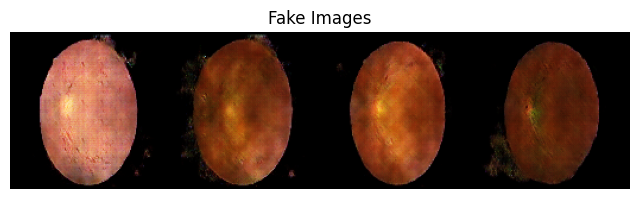

[61/20000][0/263]	Loss_D: 0.9985	Loss_G: 4.2861	D(x): 1.0000	D(G(z)): 0.6311 / 0.0241
[62/20000][0/263]	Loss_D: 0.0222	Loss_G: 5.1116	D(x): 1.0000	D(G(z)): 0.0219 / 0.0065
[63/20000][0/263]	Loss_D: 0.1938	Loss_G: 3.2934	D(x): 0.8666	D(G(z)): 0.0382 / 0.0389
[64/20000][0/263]	Loss_D: 0.0512	Loss_G: 5.1679	D(x): 0.9998	D(G(z)): 0.0490 / 0.0159
[65/20000][0/263]	Loss_D: 2.2214	Loss_G: 8.5687	D(x): 0.2759	D(G(z)): 0.0003 / 0.0058
[66/20000][0/263]	Loss_D: 1.3925	Loss_G: 2.4946	D(x): 0.3100	D(G(z)): 0.0514 / 0.1601
[67/20000][0/263]	Loss_D: 0.1787	Loss_G: 3.0866	D(x): 0.9982	D(G(z)): 0.1557 / 0.0560
[68/20000][0/263]	Loss_D: 0.0344	Loss_G: 4.7020	D(x): 0.9999	D(G(z)): 0.0336 / 0.0104
[69/20000][0/263]	Loss_D: 0.0191	Loss_G: 6.1162	D(x): 0.9883	D(G(z)): 0.0072 / 0.0025
[70/20000][0/263]	Loss_D: 0.0613	Loss_G: 4.1109	D(x): 0.9899	D(G(z)): 0.0494 / 0.0265
[71/20000][0/263]	Loss_D: 0.0513	Loss_G: 3.4727	D(x): 1.0000	D(G(z)): 0.0498 / 0.0317
[72/20000][0/263]	Loss_D: 0.1421	Loss_G: 3.4610	D(x): 

In [15]:
# Training

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = noise#torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
noise_list = []

if __name__=='__main__':
    print("Starting Training Loop...")
    #netG.load_state_dict(torch.load('/kaggle/input/weights/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/input/weights/discriminator.weight'))#,map_location=torch.device('cpu')
    #netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))#,map_location=torch.device('cpu')
    flag=0
    for epoch in range(EPOCH_NUM):
        noise_list.append(noise)
        for i, data in enumerate(dataloader, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            #print('real_label: ',label.shape)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            #print('output_label: ',output.shape)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward(retain_graph=True)
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            
            # Generate batch of latent vectors
            #noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            #print('fake_label: ',label.shape)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward(retain_graph=True)
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward(retain_graph=True)
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 263 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        if ((epoch+1)%5==0):
            avg_G_Loss=sum(G_losses[-5:])/5
            avg_D_Loss=sum(D_losses[-5:])/5
            if avg_G_Loss>=20 or avg_D_Loss>=5 or avg_D_Loss==0:
                print('Exited')
                break
        
        if ((epoch+1)%100==0):
            print("........Saving.......")
            %mkdir /kaggle/working/{epoch+1}
            torch.save(netG.state_dict(), f'/kaggle/working/{epoch+1}/generator.weight')
            torch.save(netD.state_dict(), f'/kaggle/working/{epoch+1}/discriminator.weight')
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            img_list.append(fake)
            display_images(img_list)

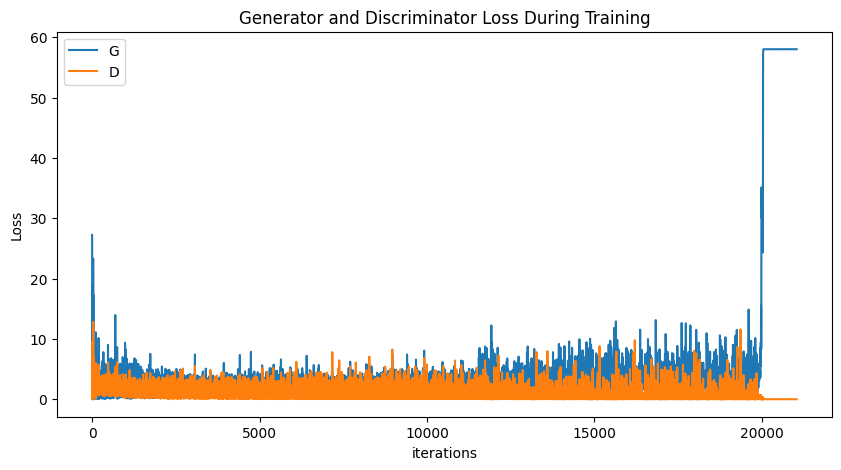

In [16]:
#plot loss graph
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([3, 128, 128])
Output Image Size:  torch.Size([132, 522, 3])


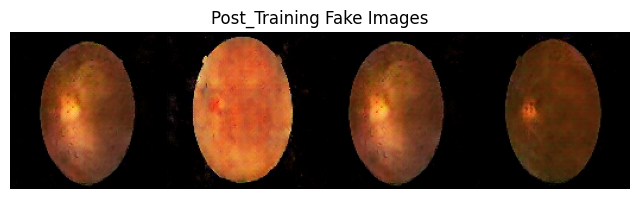

In [19]:
generate_Image()

In [ ]:
#%lsmagic
#%rm -rf /kaggle/working/*
#%tar -cf outputs.tar /kaggle/working/Generated_Batch
#%apt update && sudo apt install zip